In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import torch.optim as optim

# Make everything double precision
#torch.set_default_tensor_type(torch.DoubleTensor)

**Motivation and problem setup**

So far in the course we have seen two models: 

***propagation of Corona***
$$ S_t = -\beta SI \quad {\rm and} \quad I_t = \beta SI - \gamma I $$
where $S$ is the precent of susceptible and $I$ is percent of infected people.

***Particle flow*** 
$$ x_t = u(x,y) \quad {\rm and} \quad y_t = v(x,y) $$
where $u$ and $v$ are functions.

For both models we have solved the dynamics (that is $S(t),I(t)$ and $x(t), y(t)$) given the initial conditions and the ODE parameters, namely $\beta$ and $\gamma$ for the SI model and $u,v$ for the particle flow model. 

However, in reality we rarely have the "true" parameters of the ODE we are after. Therefore, it is impossible in most cases to have a predictive model before observing some real data.

We consider the data of the number of COVID dases in BC

**Loading and plotting COVID data using pandas**

We now load and plot COVID data. We use pandas for dealing with the csv file. pandas is a python package that handels many types of data. It is particularly suited to deal with text data.

In [2]:
# Open data from URL using pandas
url = 'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv' 

df = pd.read_csv(url)
 
# This is what the data looks like 
print(df)


      pruid                  prname  ... avgdeaths_last7 avgratedeaths_last7
0        35                 Ontario  ...             NaN                 NaN
1        59        British Columbia  ...             NaN                 NaN
2         1                  Canada  ...             NaN                 NaN
3        35                 Ontario  ...             NaN                 NaN
4        59        British Columbia  ...             NaN                 NaN
...     ...                     ...  ...             ...                 ...
5842     60                   Yukon  ...             0.0                0.00
5843     61   Northwest Territories  ...             0.0                0.00
5844     62                 Nunavut  ...             0.0                0.00
5845     99  Repatriated travellers  ...             0.0                 NaN
5846      1                  Canada  ...            29.0                0.08

[5847 rows x 39 columns]


In [3]:
# Extract data for BC 
D = df["prname"]
A = df.loc[df['prname'] == "British Columbia"]
print(A.columns)


Index(['pruid', 'prname', 'prnameFR', 'date', 'update', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numtests', 'numrecover',
       'percentrecover', 'ratetested', 'ratetests', 'numtoday', 'percentoday',
       'ratetotal', 'ratedeaths', 'numdeathstoday', 'percentdeath',
       'numtestedtoday', 'numteststoday', 'numrecoveredtoday', 'percentactive',
       'numactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14',
       'numdeaths_last14', 'ratedeaths_last14', 'numtotal_last7',
       'ratetotal_last7', 'numdeaths_last7', 'ratedeaths_last7',
       'avgtotal_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7'],
      dtype='object')


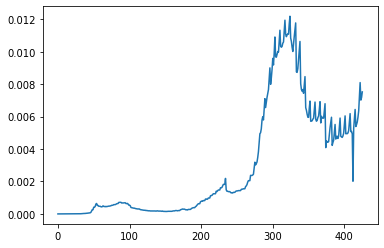

In [4]:
# Take the date column
T = A.date
# Convert it to dtype date
T = pd.to_datetime(T)
# Make it day number
base_date = T.min()
t = T.map(lambda date : (pd.Timestamp(date) - base_date).days )

# get the number of confirmed cases per day 
Iobs = pd.to_numeric(A.numactive)

t = t.to_numpy()
Iobs = Iobs.to_numpy()
# Normalize S relative to exposed BC pop
Iobs = Iobs/1e6
# plot the number of active cases
plt.plot(t,Iobs)


**Comparing the data to simulation**

Now when we have the data we can compare it to the SIR model. To this end we use the simulation we generated previously. Below is the forward Euler discretization applied to the SIR model, assuming some parameters $\beta$ and $\gamma$. 

Note that while we assume that $\gamma$ is fixed, $\beta$ can change. Recall that $\beta$ describes the interaction between succeptible and infected people. Such interaction can change when we apply masks or social distancing.

In [5]:
def SIRmodel(S0,I0,beta,gamma,n,dt):

  SS = torch.zeros(n+1,dtype=torch.float32)
  II = torch.zeros(n+1,dtype=torch.float32)
  t = torch.zeros(n+1,dtype=torch.float32)
  
  beta = torch.relu(beta)
  S = S0
  I = I0
  SS[0] = 1.0*S
  II[0] = 1.0*I
  for i in range(1,n+1):
    Sold = S
    S = S - dt*beta[i-1]*S*I
    I = (1.0 + dt*beta[i-1]*Sold - dt*gamma)*I
    t[i]  = t[i-1] + dt
    SS[i] = S
    II[i] = I
    
  return SS, II, t

Next we run the simulation and plot it together with the true data. We can play with parameters, namely $\beta$ and $\gamma$ to see how well we can the simulation predict the real data. You can see that it is actually quite difficult to do so when playing with the parameters manually.

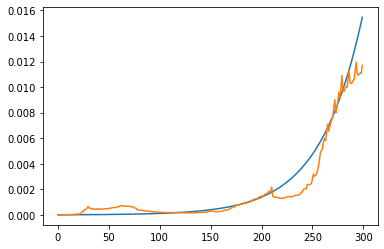

In [6]:

S0 = 0.99999
I0 = 0.00001
n  = Iobs.shape[0]

beta = 0.04*torch.ones(n,dtype=torch.float32)
gamma = 0.015
Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,n,1)
plt.plot(tc[:300],Ic[:300].detach(),tc[:300],Iobs[:300])

While we can predict the general trend of the first 270 days or so, we fail in predicting the rest or even smaller oscilations. To this end we will need to use a time variying $\beta$.

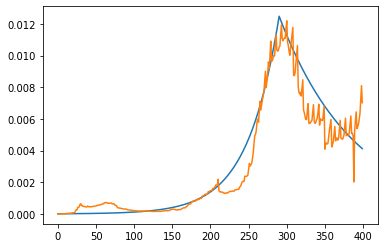

In [7]:
S0 = 0.99999
I0 = 0.00001
n  = Iobs.shape[0]

# beta 
beta = 0.04*torch.ones(n,dtype=torch.float32)
# change beta after 290 days
beta[290:] = 0.005
gamma = 0.015
Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,n,1)
plt.plot(tc[:400],Ic[:400].detach(),tc[:400],Iobs[:400])

Indeed, the kink in the graph represents the time COVID regulation became much harsher. 

This $\beta$ gives a general idea of what happened. To get more details we need to adjust $\beta$ such that the lines fit. This is too complicated to do manually so we turn to computerized methods of doing it.


**The basic idea of data fitting**

We have simulated (computed) data $I_c$ and we have the real data $I_{\rm obs}$. How do we know if they are similar?

This is done by introducing the idea of a loss function.
The loss function is typically small if $I_c$ and $I_{\rm obs}$ are similar. Below are a few examples of loss functions

Mean Square Error
$$ MSE = {\frac 1n} \|I_c - I_{\rm obs}\|^2 $$

$L_1$ Error
$$ MSE = {\frac 1n} \sum_n |I_{c_i} - I_{\rm obs_i}| $$


Correlation loss
$$ Corr = -{\frac 1n} I_c^{\top}I_{\rm obs} $$
The correlation is less sensitive to the amplitudes of the data and is related to the shape.

Choosing the "right" loss depends on the problem we wish to solve. The most used loss is the mean square error loss.

Given the loss we can try to predict what is the "best" $\beta$ to be used. The best one is the one that minimizes the loss as it best fit the data (this is up to cross validation)

**Minimizing a function**

Suppose that we have a function of some parameters $\beta$, how should we minimize the function with respect to it?

One way to do it (which you may have learned in calculus) is to solve for the minimum explicitly, however, this is almost never doable. A more practical approach is to use an iterative procidure.

Assume that we have a point $\beta_k$ and that we have an associated loss
$loss(\beta_k)$. Rather than trying to find an optimal point we try to find a new point $\beta_{k+1}$ such that $loss(\beta_{k+1}) < loss(\beta_k)$. To do that we write $\beta_{k+1} = \beta_k + \delta \beta$ and use Taylor's theorem that states that
$$ loss(\beta_{k+1}) = loss(\beta_{k} + \delta \beta) = loss(\beta_{k}) + (\nabla_{\beta} loss)^{\top} \delta \beta + H.O.T $$
Negglecting the Higher Order Terms we see that the loss at $\beta_{k+1}$ is equal to the loss at $\beta_k$ and a correction term of the form $(\nabla_{\beta} loss)^{\top} \delta \beta$. This term is an inner product between two vectors, the gradient of the loss with respect to $\beta$ and the perturbation $\delta \beta$. To make the loss as small as possible we therefore choose
$$ \delta \beta = - \mu \nabla_{\beta} loss $$
where $\mu$ is a parameter that is chosen such that indeed the H.O.T is small relative to the first term in the Taylor's expansion.

This leads to the following algorithm

Steepest Descent
1. Compute $loss(\beta)$ and $\nabla_{\beta} loss$
2. Set $\beta \leftarrow \beta - \mu \nabla_{\beta} loss$


**Computing Derivatives**

In principle we all think we know how to compute derivatives. Indeed, this is a basic operation and we all learned how to compute derivatives of polynomials and other basic functions. 

However, what if we have a more complex function. Consider for a moment the following function

In [29]:
def simpleIntegrator(y0,beta,dt,n):
  Y = torch.zeros(n+1)
  y = y0
  Y[0] = y
  for i in range(n):
    y = y + dt*beta[i]*y
    Y[i+1] = y

  return Y 
  
   
    

In [28]:
# Make the data torch variable
Iobs = torch.tensor(Iobs,dtype=torch.float32)
N = torch.numel(Iobs)-1
# step size
mu      = 1e-3

numiter = 10

for i in range(numiter):
    #  compute function and its gradient
    I0 = Iobs[0]
    S0 =  1.0-I0
    
    # Make beta a parameter that we can compute gradients 
    beta = torch.tensor(beta, requires_grad=True)
    # Evaluate the objective function
    Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,N,1)
    loss = F.mse_loss(Ic,Iobs)/F.mse_loss(Iobs*0,Iobs)
    
    # Compute gradients
    loss.backward()
    gradLoss = beta.grad
    # update the parameters
    with torch.no_grad():
      beta -= mu*gradLoss
      
      
    if i%1==0:
      print(i, loss.item(), torch.norm(gradLoss).item())
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


0 0.03188282623887062 0.3657950460910797
1 0.0317496620118618 0.36231154203414917
2 0.031619004905223846 0.3588975965976715
3 0.03149080649018288 0.3555504083633423
4 0.03136497735977173 0.35227078199386597
5 0.031241431832313538 0.34905579686164856
6 0.031120162457227707 0.3459048271179199
7 0.031001083552837372 0.34281662106513977
8 0.030884049832820892 0.33978939056396484
9 0.030769100412726402 0.3368232846260071


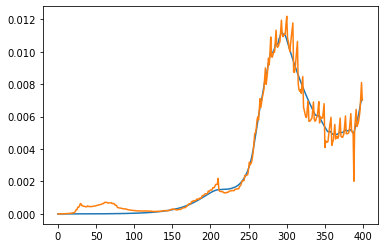

In [45]:
#Sc, Ic, tc = SIRmodel(S0,I0,beta,gamma,N,1)
plt.plot(tc[:400],Ic[:400].detach(),tc[:400],Iobs[:400])


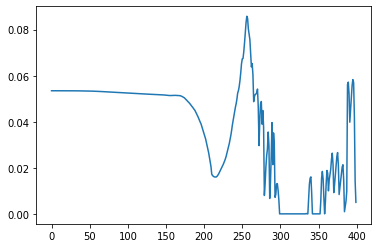

In [46]:
plt.plot(beta.detach())

In [ ]:
def SD(func,theta0,numiter,mu):
# SD(func,theta0,numiter,mu)
    
    theta = theta0

    for i in range(numiter):
        #  compute function and its gradient
        f = func(theta)
        # Compute gradients
        f.backward()
        gradf = theta.grad
        
        print(i, f, torch.norm(gradf))
        
        #  update theta <- theta - mu*grad f
        with torch.no_grad():
            theta -= mu*gradf
            
            theta.grad.fill_(0.0)
            
    return theta
    
#
#  return theta

In [ ]:
D^TG^TW^T\sigma(K(WGDu))

optuna

In [ ]:
print(b)